In [1]:
import os
import sys

sys.stderr = open(os.devnull, "w")
    
import logging
logging.getLogger('tensorflow').disabled = True
# Suppress logging warnings
os.environ["GRPC_VERBOSITY"] = "FATAL"
os.environ["GLOG_minloglevel"] = "3"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist
import keras_tuner as kt

import numpy as np
from matplotlib import pyplot as plt


seed = 42
tf.keras.utils.set_random_seed(seed)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(1)

os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir="

# Suppress absl logging (responsible for XLA, CUDA messages)
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("absl").setLevel(logging.ERROR)

tf.get_logger().setLevel("ERROR")
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("absl").setLevel(logging.ERROR)
tf.config.optimizer.set_jit(False)  # Disable XLA to avoid logs

E0000 00:00:1738776314.464030   28263 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738776314.574791   28263 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Blind source separation

This project aims to separate an image, formed as the sum of two images, into its original components.

The two source images, img1 and img2, are drawn from different datasets: MNIST and Fashion-MNIST, respectively.

No preprocessing is allowed. The neural network receives the combined image (img1 + img2) as input and outputs the predicted components (hat_img1,hat_img2).

Performance is evaluated using the mean squared error (MSE) between the predicted and ground-truth images.

Both datasets (MNIST and Fashion-MNIST) are grayscale. For simplicity, all samples are padded to a (32,32) resolution.

In [2]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
print(np.shape(mnist_x_train))
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
#normnalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
print(np.shape(mnist_x_train))
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

(60000, 28, 28)
(60000, 32, 32)


In [3]:
print(np.shape(mnist_x_train))

(60000, 32, 32)


Here is a simple datagenerator.

In [4]:
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = (x1[num1], x2[num2])

        yield x_data, y_data

Let us define a generator with batchsize=1 and let's test it.

In [5]:
onegen = datagenerator(mnist_x_test,fashion_mnist_x_test,1)

Let us look at some input-output pairs

In [6]:
def show_images(x,y1,y2):
    fig, ax = plt.subplots(1,3,figsize=(12,4))
    ax[0].imshow(x,cmap='gray')
    ax[0].title.set_text('Input')
    ax[0].axis('off')
    ax[1].imshow(y1,cmap='gray')
    ax[1].title.set_text('mnist')
    ax[1].axis('off')
    ax[2].imshow(y2,cmap='gray')
    ax[2].title.set_text('fashion_mnist')
    ax[2].axis('off')
    plt.show()

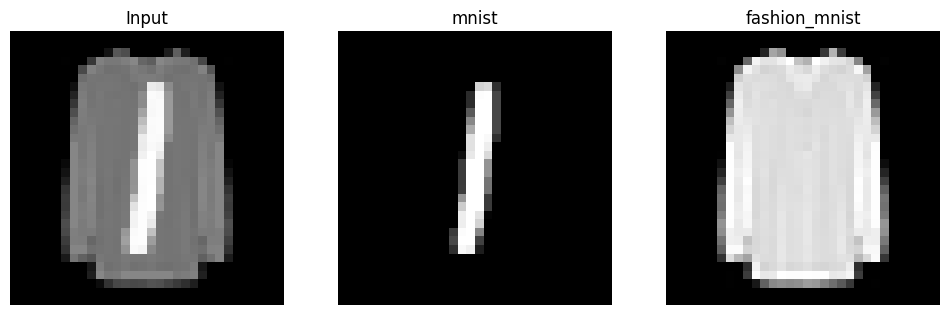

In [7]:
x,(y1,y2)=next(onegen)
show_images(x[0],y1[0],y2[0])

# Model evalaution

Let us define the test generator.

In [8]:
testgen = datagenerator(mnist_x_test,fashion_mnist_x_test,5000)

eval_samples_x, (eval_samples_y1, eval_sample2) = next(testgen)

We test a model returning twice the input image. You will need to replace it with your own predictive model.

In [17]:
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# def build_unet_tuned(hp):
#     inputs = layers.Input((32, 32, 1))
    
#     # Tune number of filters
#     filters = hp.Choice('filters', values=[16, 32, 64])

#     # Encoder
#     c1 = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(inputs)
#     c1 = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(c1)
#     p1 = layers.MaxPooling2D((2, 2))(c1)
    
#     c2 = layers.Conv2D(filters * 2, (3, 3), activation='relu', padding='same')(p1)
#     c2 = layers.Conv2D(filters * 2, (3, 3), activation='relu', padding='same')(c2)
#     p2 = layers.MaxPooling2D((2, 2))(c2)
    
#     # Bottleneck
#     bn = layers.Conv2D(filters * 4, (3, 3), activation='relu', padding='same')(p2)
    
#     # Decoder for MNIST
#     u1_mnist = layers.Conv2DTranspose(filters * 2, (3, 3), strides=(2, 2), padding='same')(bn)
#     u1_mnist = layers.concatenate([u1_mnist, c2])
#     c3_mnist = layers.Conv2D(filters * 2, (3, 3), activation='relu', padding='same')(u1_mnist)
    
#     u2_mnist = layers.Conv2DTranspose(filters, (3, 3), strides=(2, 2), padding='same')(c3_mnist)
#     u2_mnist = layers.concatenate([u2_mnist, c1])
#     c4_mnist = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(u2_mnist)
    
#     output_mnist = layers.Conv2D(1, (1, 1), activation='sigmoid', name='mnist_output')(c4_mnist)
    
#     # Decoder for Fashion-MNIST
#     u1_fashion = layers.Conv2DTranspose(filters * 2, (3, 3), strides=(2, 2), padding='same')(bn)
#     u1_fashion = layers.concatenate([u1_fashion, c2])
#     c3_fashion = layers.Conv2D(filters * 2, (3, 3), activation='relu', padding='same')(u1_fashion)
    
#     u2_fashion = layers.Conv2DTranspose(filters, (3, 3), strides=(2, 2), padding='same')(c3_fashion)
#     u2_fashion = layers.concatenate([u2_fashion, c1])
#     c4_fashion = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(u2_fashion)
    
#     output_fashion = layers.Conv2D(1, (1, 1), activation='sigmoid', name='fashion_output')(c4_fashion)
    
#     model = models.Model(inputs, [output_mnist, output_fashion])
    
#     # Tune learning rate
#     learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
#     optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
#     model.compile(optimizer=optimizer, loss='mse', metrics=['mse', 'mse'])
    
#     return model

def encoder_block(inputs, num_filters):
    """
    Blocco encoder composto da:
      - 2 convoluzioni 3x3 con attivazione ReLU (padding "same")
      - Un max pooling 2x2 per il downsampling
    Restituisce:
      - Le feature map prima del pooling (da utilizzare nelle skip connection)
      - L'output dopo il pooling.
    """
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(inputs)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.Activation('relu')(x)
    p = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    """
    Blocco decoder composto da:
      - UpSampling tramite Conv2DTranspose (2x2) per aumentare la risoluzione
      - Concatenazione con le feature skip (dall'encoder)
      - 2 convoluzioni 3x3 con attivazione ReLU
    """
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

def unet_separation_model(input_shape=(32, 32, 1)):
    """
    Modello U-Net per la separazione di un'immagine combinata nelle sue due componenti.
    L'output è costituito da due tensori separati, ognuno di shape (32, 32):
       - 'mnist_output'    : stima di img1 (MNIST)
       - 'fashion_output'  : stima di img2 (Fashion-MNIST)
    """
    inputs = tf.keras.layers.Input(input_shape)
    
    # Encoder
    s1, p1 = encoder_block(inputs, 32)   # s1: (32,32,32) ; p1: (16,16,32)
    s2, p2 = encoder_block(p1, 64)         # s2: (16,16,64) ; p2: (8,8,64)
    s3, p3 = encoder_block(p2, 128)        # s3: (8,8,128) ; p3: (4,4,128)
    s4, p4 = encoder_block(p3, 256)        # s4: (4,4,256) ; p4: (2,2,256)
    
    # Bottleneck
    b = tf.keras.layers.Conv2D(512, 3, padding='same')(p4)
    b = tf.keras.layers.Activation('relu')(b)
    b = tf.keras.layers.Conv2D(512, 3, padding='same')(b)
    b = tf.keras.layers.Activation('relu')(b)
    
    # Decoder
    d1 = decoder_block(b, s4, 256)  # Output: (4,4,256)
    d2 = decoder_block(d1, s3, 128) # Output: (8,8,128)
    d3 = decoder_block(d2, s2, 64)  # Output: (16,16,64)
    d4 = decoder_block(d3, s1, 32)  # Output: (32,32,32)
    
    # Output layer: convoluzione 1x1 che produce 2 canali (uno per ciascuna immagine)
    combined_output = tf.keras.layers.Conv2D(2, 1, padding='same', activation='sigmoid')(d4)
    
    # Separiamo i due canali in output distinti
    # Il canale 0 corrisponde a MNIST, il canale 1 a Fashion-MNIST.
    output1 = tf.keras.layers.Lambda(lambda x: x[..., 0], name='mnist_output')(combined_output)
    output2 = tf.keras.layers.Lambda(lambda x: x[..., 1], name='fashion_output')(combined_output)
    
    # Se preferisci usare Reshape esplicito (anche se qui non è strettamente necessario)
    output1 = tf.keras.layers.Reshape((32, 32), name='mnist_output_reshaped')(output1)
    output2 = tf.keras.layers.Reshape((32, 32), name='fashion_output_reshaped')(output2)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=[output1, output2], name="U-Net_Image_Separation")
    
    # Compilazione del modello
    # Utilizziamo il Mean Squared Error (MSE) come loss per entrambi gli output.
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='mse',
                  metrics=['mse', 'mse'])
    return model

In [10]:
from keras_tuner import Hyperband

# Define the tuner
tuner = Hyperband(
    build_unet_tuned,
    objective='val_loss',
    executions_per_trial=1,  # How many times to train each model
    directory='tuner_results',  # Where to save the results
    project_name='blind_source_separation2',
    seed=seed
)

NameError: name 'build_unet_tuned' is not defined

In [11]:
batch_size = 32
train_generator = datagenerator(mnist_x_train, fashion_mnist_x_train, batch_size)
val_generator = datagenerator(mnist_x_test, fashion_mnist_x_test, batch_size)

tuner.search(
    train_generator,
    epochs=5,  # Keep low initially, increase later
    steps_per_epoch=len(mnist_x_train) // batch_size,
    validation_data=val_generator,
    validation_steps=len(mnist_x_test) // batch_size
)

Trial 9 Complete [00h 02m 04s]
val_loss: 0.10954488813877106

Best val_loss So Far: 0.08889327198266983
Total elapsed time: 00h 16m 56s


In [12]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best Filters: {best_hps.get('filters')}
Best Learning Rate: {best_hps.get('learning_rate')}
""")

# Build best model
best_model = tuner.hypermodel.build(best_hps)

# Train best model with more epochs
history = best_model.fit(
    train_generator,
    epochs=50,  # Train longer on best configuration
    steps_per_epoch=len(mnist_x_train) // batch_size,
    validation_data=val_generator,
    validation_steps=len(mnist_x_test) // batch_size
)


Best Filters: 64
Best Learning Rate: 0.001

Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 120s 39ms/step - fashion_output_loss: 0.1581 - fashion_output_mse: 0.1581 - loss: 0.2457 - mnist_output_loss: 0.0876 - mnist_output_mse: 0.0876 - val_fashion_output_loss: 0.1582 - val_fashion_output_mse: 0.1582 - val_loss: 0.2457 - val_mnist_output_loss: 0.0875 - val_mnist_output_mse: 0.0875
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 70s 38ms/step - fashion_output_loss: 0.1585 - fashion_output_mse: 0.1585 - loss: 0.2442 - mnist_output_loss: 0.0858 - mnist_output_mse: 0.0858 - val_fashion_output_loss: 0.1582 - val_fashion_output_mse: 0.1582 - val_loss: 0.2455 - val_mnist_output_loss: 0.0874 - val_mnist_output_mse: 0.0874
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 70s 37ms/step - fashion_output_loss: 0.1583 - fashion_output_mse: 0.1583 - loss: 0.2440 - mnist_output_loss: 0.0857 - mnist_output_mse: 0.0857 - val_fashion_output_loss: 0.1590 - val_fashion_output_mse: 0.1590 - val_loss: 0.2463 - val_mnist_out

KeyboardInterrupt: 

In [18]:
model = unet_separation_model(input_shape=(32, 32, 1))
model.summary()
from tensorflow.keras.utils import plot_model

plot_model(model, rankdir="LR")

Model: "U-Net_Image_Separation"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 32, 32,    │        320 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_54       │ (None, 32, 32,    │          0 │ conv2d_57[0][0]   │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 32, 32,    │      9,248 │ activation_54[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_55       │ (None, 32, 32,    │          0 │ conv2d_58[0][0]   │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 16, 16,    │          0 │ activation_55[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 16, 16,    │     18,496 │ max_pooling2d_12… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_56       │ (None, 16, 16,    │          0 │ conv2d_59[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 16, 16,    │     36,928 │ activation_56[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_57       │ (None, 16, 16,    │          0 │ conv2d_60[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 8, 8, 64)  │          0 │ activation_57[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 8, 8, 128) │     73,856 │ max_pooling2d_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_58       │ (None, 8, 8, 128) │          0 │ conv2d_61[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 8, 8, 128) │    147,584 │ activation_58[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_59       │ (None, 8, 8, 128) │          0 │ conv2d_62[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 4, 4, 128) │          0 │ activation_59[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 4, 4, 256) │    295,168 │ max_pooling2d_14… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_60       │ (None, 4, 4, 256) │          0 │ conv2d_63[0][0] 

 Total params: 7,759,554 (29.60 MB)

 Trainable params: 7,759,554 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [19]:
# Define the batch size
batch_size = 32

# Create the generators
train_generator = datagenerator(mnist_x_train, fashion_mnist_x_train, batch_size)
val_generator = datagenerator(mnist_x_test, fashion_mnist_x_test, batch_size)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

steps_per_epoch = len(mnist_x_train) // batch_size
validation_steps = len(mnist_x_test) // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=5,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 96s 41ms/step - fashion_output_reshaped_loss: 0.1587 - fashion_output_reshaped_mse: 0.1587 - loss: 0.2471 - mnist_output_reshaped_loss: 0.0884 - mnist_output_reshaped_mse: 0.0884 - val_fashion_output_reshaped_loss: 0.1589 - val_fashion_output_reshaped_mse: 0.1589 - val_loss: 0.2468 - val_mnist_output_reshaped_loss: 0.0878 - val_mnist_output_reshaped_mse: 0.0878 - learning_rate: 0.0010
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 73s 39ms/step - fashion_output_reshaped_loss: 0.1585 - fashion_output_reshaped_mse: 0.1585 - loss: 0.2441 - mnist_output_reshaped_loss: 0.0856 - mnist_output_reshaped_mse: 0.0856 - val_fashion_output_reshaped_loss: 0.1569 - val_fashion_output_reshaped_mse: 0.1569 - val_loss: 0.2437 - val_mnist_output_reshaped_loss: 0.0868 - val_mnist_output_reshaped_mse: 0.0868 - learning_rate: 0.0010
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 73s 39ms/step - fashion_output_reshaped_loss: 0.1582 - fashion_output_reshaped_mse: 0.1582 - loss: 0.

In [20]:
def eval_model(model):
  x, (y1,y2) = next(testgen)
# 
  # use model.predict to get predictions. Here we just call model
  pred1, pred2 = model.predict(x)

  return (np.mean((pred1-y1)**2) + np.mean((pred2-y2)**2) / 2)

In [22]:
repeat_eval = 2
eval_results = []
for i in range(repeat_eval):
  eval_results.append(eval_model(model))
print("mse = ", np.mean(eval_results))
print("standard deviation = ", np.std(eval_results))

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
mse =  0.16647061225325005
standard deviation =  0.00043144530423999683


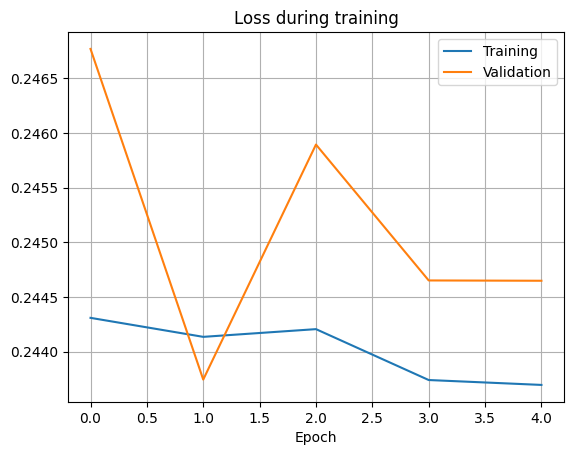

In [24]:
def display_history(history):
    mse_training = history.history['loss']
    # acc_training = history.history['accuracy']

    mse_val = history.history['val_loss']
    # acc_val = history.history['val_accuracy']

    # Visualize the behavior of the loss
    plt.plot(mse_training)
    plt.plot(mse_val)
    plt.grid()
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

    # # and of the accuracy
    # plt.plot(acc_training)
    # plt.plot(acc_val)
    # plt.grid()
    # plt.title('Accuracy during training')
    # plt.xlabel('Epoch')
    # plt.legend(['Training', 'Validation'])
    # plt.show()

# print(history.model.summary())
display_history(history)


 --------- IMAGE 1 --------- 



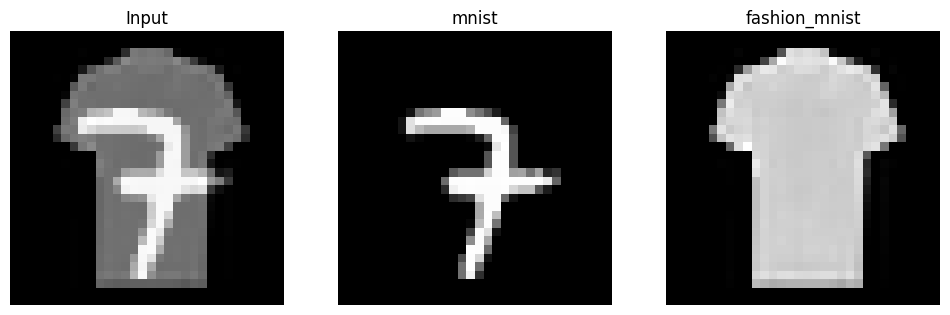

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predictions:


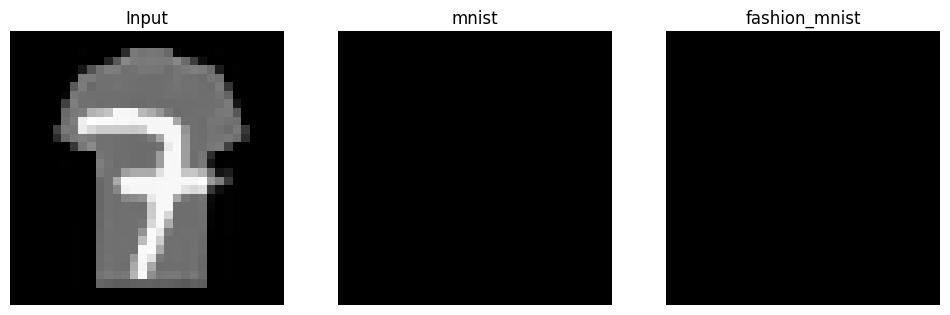

In [36]:
batch_visual_gen = 8
visual_test_generator = datagenerator(mnist_x_test, fashion_mnist_x_test, batch_visual_gen)

def visual_test(generator, model, n_images=1):
    x_test, y_test = next(generator)

    for i in range(n_images):
        print(f'\n --------- IMAGE {i+1} --------- \n')
        # Create the grid
        show_images(x_test[i], y_test[0][i], y_test[1][i])
        
        # Get the prediction
        pred1, pred2 = model.predict(x_test[i][np.newaxis, ...])
        
        # Display the prediction
        print('Predictions:')
        show_images(x_test[i], pred1[0], pred2[0])
        print('\n')
        
        plt.show()
        
visual_test(visual_test_generator, model, n_images=1)

# What to deliver
As usual, you are supposed to deliver a single notebook that is supposed to run on colab. The notebook should be adequately commented, contain a full trace of the training, the computation of the mse in the form specified above and a few examples.

Good Work!